# Imports

In [1]:
import numpy as np
import scipy
from scipy.stats import unitary_group
from sklearn.linear_model import LinearRegression

In [2]:
import seaborn as sns
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.colormaps['cool']

In [4]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import jacfwd, jacrev

# Choose device : GPUs or CPU

In [5]:
!nvidia-smi

Fri Sep 15 17:24:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   39C    P0    25W / 250W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   

If the above returns an issue choose CPU otherwise choose GPU, and select the kdevice with the most RAM.

In [6]:
ENV_DEV = 'GPU'
# ENV_DEV = 'CPU'
assert ENV_DEV=='GPU' or ENV_DEV=='CPU'

In [7]:
if ENV_DEV == 'GPU':
    gpus = jax.devices('gpu')
    print(gpus)
    print("choose GPU here")
    dev = gpus[3]
elif ENV_DEV == 'CPU':
    cpus = jax.devices('cpu')
    print(cpus)
    print("chooseCPU here")
    dev = cpus[0]
print(dev)

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=2, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=3, process_index=0, slice_index=0)]
choose GPU here
gpu:3


In [8]:
select_dev = False

# Define Functions

run everything and check that all tests are passed successfully and that the precisions are small enough

In [10]:
def Paulis():
    I = np.array([[+1,+0],[+0,+1]])
    X = np.array([[+0,+1],[+1,+0]])
    Y = np.array([[+0,-1j],[+1j,+0]])
    Z = np.array([[+1,+0],[+0,-1]])
    return I,X,Y,Z

In [11]:
def eigvalstopoly(eigvals,deg):
    r"""transforms eigenvalues into polynomials

    Args:
        eigvals [n]: array of integer eigenvalues values usually 2 to the number of qubits
        deg: max degree covered

    Returns:
        poly: [n,2*deg+1] : eigenvalues as polynomials
    """
    poly = np.zeros((eigvals.size,2*deg+1))
    for k,eigval in enumerate(eigvals):
        poly[k,int(np.round(eigval+deg))] = 1
        # poly.at[k,int(jnp.round(eigval+deg))].set(1)
    return poly

In [12]:
def test_eigvalstopoly():
    eigvals_test = np.array([-2,0,3])
    result = np.array([[0., 0., 1., 0., 0., 0., 0., 0., 0.],[0., 0., 0., 0., 1., 0., 0., 0., 0.],[0., 0., 0., 0., 0., 0., 0., 1., 0.]])
    assert np.allclose(eigvalstopoly(eigvals_test,deg=4),result)

test_eigvalstopoly()

In [13]:
def polytokernel(P,deg=None):
    r"""transforms polynomials into convolving kernels

    Args:
        P [n,deg]: array of integer eigenvalues values usually 2 to the number of qubits
        deg: max degree covered

    Returns:
        poly: [n,2*deg+1] : eigenvalues as polynomials
    """
    if deg is None:
        deg = (P.shape[1]-1)//2
    MP = np.zeros((P.shape[0],2*deg+1,2*deg+1))
    for k in reversed(range(1,deg+1)):
        MP[:,:,deg-k] = np.concatenate([P[:,k:],np.zeros((P.shape[0],k))],axis=1)
    MP[:,:,deg] = P
    for k in range(1,deg+1):
        MP[:,:,deg+k] = np.concatenate([np.zeros((P.shape[0],k)),P[:,:-k]],axis=1)
    return MP

In [14]:
def test_polytokernel():
    p1 = np.array([0,0,1,5,-1,0,0])
    p2 = np.array([0,0,-2,1,2,0,0])
    P = np.stack([p1,p2])
    MP = polytokernel(P)
    
    q = np.array([0,0,2,1,5,0,0])
    
    p1q_a = MP[0] @ q
    p1q_b = np.convolve(p1,q, mode='same')
    p2q_a = MP[1] @ q
    p2q_b = np.convolve(p2,q, mode='same')
    
    assert np.allclose(p1q_a,p1q_b)
    assert np.allclose(p2q_a,p2q_b)

test_polytokernel()

In [15]:
def apply_conv(MP,state):
    return jnp.einsum('ijk,ik->ij',MP,state)

In [16]:
def test_applyconv():
    states = jnp.stack([np.array([[0,0,1,0,-1,0,0],[0,0,0,2,0,0,0],[0,0,1,2,3,0,0],[0,0,5,0,0,0,0]])]*10,axis=2)
    p1 = np.array([0,0,1,5,-1,0,0])
    p2 = np.array([0,0,-2,1,2,0,0])
    P = np.stack([p1,p2,p1,p2])
    MP = polytokernel(P)
    _fun = lambda state : apply_conv(MP,state)
    test_res = jit(vmap(_fun), device = dev)(states.transpose([2,0,1]))
    
    for k in range(4):
        ta = np.convolve(P[k],states[k,:,0], mode='same')
        tb = test_res[k,k,:]
        assert np.allclose(ta,tb)

test_applyconv()

In [17]:
def eval_trigpoly(P,xs):
    deg = (P.size-1)//2
    eikx = np.exp(1j*np.einsum('i,j->ij',np.arange(-deg,deg+1),xs))
    return np.einsum('i,ij->j',P,eikx)

In [18]:
def test_eval_trigpoly():

    xs = np.linspace(0,2*np.pi)
    #test 1
    P = np.array([0,1,2,3,0])
    ta = eval_trigpoly(P,xs)
    tb = np.exp(-xs*1j) + 2 + 3 * np.exp(xs*1j)
    
    assert np.allclose(ta,tb)

    #test 2
    p1 = np.array([0,0,1,4,-1,0,0]) # 4 - i 2sx
    p2 = np.array([0,0,2,1,2,0,0]) # 1 + 4cx
    q = np.convolve(p1,p2, mode='same') # [ 0  2  9  4  7 -2  0] 4 + 16cx -2isx -i8sxcx
    
    ys1 = eval_trigpoly(p1,xs)
    ys2 = eval_trigpoly(p2,xs)
    ysq = eval_trigpoly(q,xs)
    
    assert np.allclose(ys1*ys2,ysq)

test_eval_trigpoly()

In [19]:
def eval_several_scpoly(Ps,xs):
    deg = (Ps.shape[0]-1)//2
    coskx = [np.cos(xs*k) for k in range(1,deg+1)]
    sinkx = [np.sin(xs*k) for k in range(1,deg+1)]
    
    sckx = np.concatenate([np.array([xs*0+1]),np.array(coskx),np.array(sinkx)])

    return np.einsum('ik,ij->kj',Ps,sckx)

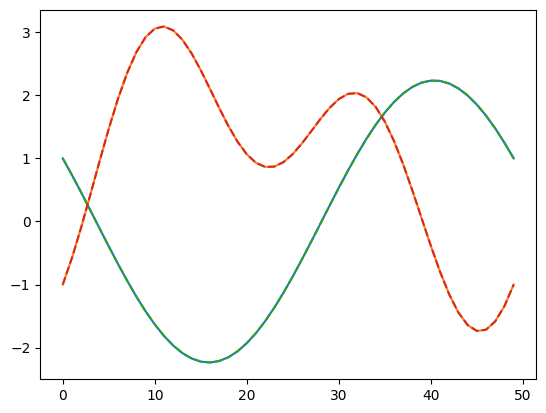

In [20]:
def test_eval_several_scpoly(boolPlot=True):
    P = np.array([[0,1,0,-2,0],[1,-1,-1,1,1]]).T
    xs = np.linspace(0,2*np.pi)
    
    ys_a = eval_several_scpoly(P,xs).T
    ys_b = np.array([np.cos(xs)-2*np.sin(xs),1-np.cos(xs)-np.cos(2*xs)+np.sin(xs)+np.sin(2*xs)]).T

    if boolPlot:
        plt.plot(ys_a)
        plt.plot(ys_b,'--')
    
    assert np.allclose(ys_a,ys_b)

test_eval_several_scpoly()

In [21]:
def trig_to_sc(obs):
    N = (obs.shape[-1]-1)//2
    one = obs[:,:,N:N+1]
    assert np.allclose(one.imag,0,atol=5e-7)
    one = one.real
    cos = (obs[:,:,:N:]+obs[:,:,:N:-1])
    assert np.allclose(cos.imag,0,atol=5e-7)
    cos = cos.real
    sin = (obs[:,:,:N:]-obs[:,:,:N:-1])
    assert np.allclose(sin.real,0,atol=5e-7)
    sin = sin.imag
    return one,cos[:,:,::-1],sin[:,:,::-1]

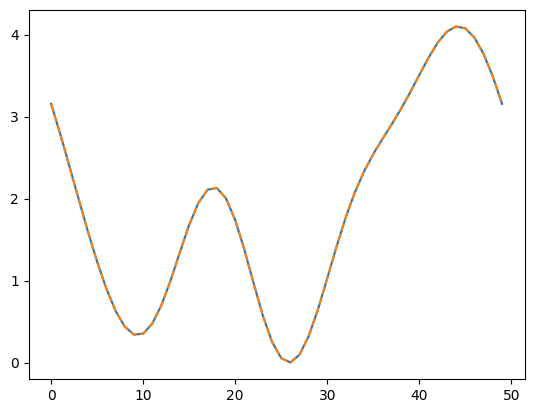

In [22]:
def test_trig_to_sc(boolPlot=True):
    xs = np.linspace(0,2*np.pi)
    
    np.random.seed(0)
    eix = (np.random.rand(5)*2-1) + 1j*(np.random.rand(5)*2-1)
    eix2 = np.convolve(eix,eix[::-1].conj())
    oscx = np.concatenate(trig_to_sc(np.expand_dims(eix2,axis=(0,1))),axis=2)
    
    ys_a = eval_trigpoly(eix2,xs)
    assert np.allclose(ys_a.imag,0)
    ys_a = ys_a.real
    ys_b = eval_several_scpoly(oscx[0].T,xs)[0,:]

    if boolPlot:
        plt.plot(ys_a)
        plt.plot(ys_b,'--')

    assert np.allclose(ys_a,ys_b)

test_trig_to_sc()

In [23]:
def thes_state(A,Bs,numlayers,thes):
    N = A.shape[0]
    
    eigA, SA = np.linalg.eigh(A)
    dA = int(np.round(np.max(np.abs(eigA))))
    
    eigBs = []
    SBs = []
    
    for B in Bs:
        eigB, SB = np.linalg.eigh(B)
        eigBs.append(eigB)
        SBs.append(SB)
        
    deg = dA * numlayers # no margin
    
    MPA = polytokernel(eigvalstopoly(eigA,deg))
    
    states = []
    
    #init
    state = np.zeros([N,2*deg+1])
    state[0,deg] = 1
    state_jnp = jnp.array(state)

    k_init = 0

    for ind_b in range(len(Bs)):
        eigB = eigBs[ind_b]
        SB = SBs[ind_b]            
        state_jnp = jnp.einsum('ij,jk->ik',np.conjugate(SB.T),state_jnp) #change basis to B
        eithB = jnp.exp(1j*eigB*thes[k_init])
        k_init += 1
        state_jnp = jnp.einsum('i,ij->ij',eithB,state_jnp) # apply B parameter
        state_jnp = jnp.einsum('ij,jk->ik',SB,state_jnp) #change basis to I
                
    for k in range(numlayers): #go to A basis
        
        state_jnp = jnp.einsum('ij,jk->ik',np.conjugate(SA.T),state_jnp) #change basis to A
        state_jnp = jnp.einsum('ijk,ik->ij',MPA,state_jnp) #convolution with generator A
        state_jnp = jnp.einsum('ij,jk->ik',SA,state_jnp) #change basis to I
        
        for ind_b in range(len(Bs)):
            eigB = eigBs[ind_b]
            SB = SBs[ind_b]            
            state_jnp = jnp.einsum('ij,jk->ik',np.conjugate(SB.T),state_jnp) #change basis to B
            eithB = jnp.exp(1j*eigB*thes[k_init])
            k_init += 1
            state_jnp = jnp.einsum('i,ij->ij',eithB,state_jnp) # apply B parameter
            state_jnp = jnp.einsum('ij,jk->ik',SB,state_jnp) #change basis to I

        states.append(state_jnp)
        # print(f"{k} out of {numlayers}")
    
    return jnp.stack(states)

In [24]:
def test_thes_state():
    I,X,Y,Z = Paulis()
    A = (np.kron(np.kron(np.kron(X,I),I),I) + np.kron(np.kron(np.kron(I,X),I),I) + np.kron(np.kron(np.kron(I,I),X),I) + np.kron(np.kron(np.kron(I,I),I),X))/2
    B = np.kron(np.kron(np.kron(Y,Y),I),I) + np.kron(np.kron(np.kron(I,I),Y),Y) + np.kron(np.kron(np.kron(I,Y),Y),I) + np.kron(np.kron(np.kron(Y,I),I),Y)
    Bs = [B]
    N = A.shape[0]
    
    xs = np.linspace(-np.pi,np.pi)
    thes = [0.5,0.6]

    #track 1
    states = thes_state(A,Bs,1,thes)
    Sa = np.array([eval_trigpoly(states[-1][k,:],xs) for k in range(N)]).T

    #track 2 
    def fun_x_thes(x):
        state = np.zeros([N])
        state[0] = 1
        ax = scipy.linalg.expm(1j*A*x)
        b1 = scipy.linalg.expm(1j*B*thes[0])
        b2 = scipy.linalg.expm(1j*B*thes[1])
        state = b2 @ ax @ b1 @ state 
        return state
    Sb = np.array([fun_x_thes(x) for x in xs])

    #compare
    # assert np.allclose(Sa,Sb)
    print(f"precision : {np.mean(np.abs(Sa-Sb))}")

test_thes_state()

precision : 2.7346525782572262e-08


In [25]:
def measurement(states,M):
    eigM, SM = np.linalg.eigh(M)
    states = jnp.einsum('ij,rsjk->rsik',np.conjugate(SM.T),states) #change basis to M
    
    #get probabilities for each coordinates
    proba_fun = vmap(vmap(vmap(lambda x : jnp.convolve(x,x[::-1].conj()))))
    obs = jnp.einsum('k,ijkl->ijl',eigM,proba_fun(states)) #change basis to M

    return obs

In [26]:
def regular_simulation(A,Bs,M,numlayers,thes):
    N = A.shape[0]
    def fun_x_thes(x):
        state = np.zeros([N])
        state[0] = 1
        k_init = 0
        for k in range(numlayers):
            ax = scipy.linalg.expm(1j*A*x)
            state = ax @ state 
            for B in Bs:
                b = scipy.linalg.expm(1j*B*thes[k_init])
                k_init += 1
                state = b @ state 
        m = np.conjugate(state.T) @ M @ state
        return state, m
    
    return fun_x_thes


In [27]:
# def test_measurement(boolPlot=True):
    
#     N = 4
#     I,X,Y,Z = Paulis()
#     xs = np.linspace(-np.pi,np.pi,53)
    
#     ## test 1
#     A = (np.kron(np.kron(np.kron(X,I),I),I) + np.kron(np.kron(np.kron(I,X),I),I) + np.kron(np.kron(np.kron(I,I),X),I) + np.kron(np.kron(np.kron(I,I),I),X))/2
#     B = np.kron(np.kron(np.kron(Y,Y),I),I) + np.kron(np.kron(np.kron(I,I),Y),Y) + np.kron(np.kron(np.kron(I,Y),Y),I) + np.kron(np.kron(np.kron(Y,I),I),Y)
#     Bs = [B]
#     M = A/2
#     thes = np.array([0.5,1.1,2.5,6.5])
    
#     #track 1
#     states = np.expand_dims(thes_state(A,Bs,2,thes),axis=0)
#     obs = measurement(states,M)
#     one,cos,sin = trig_to_sc(obs)
#     ocs = np.concatenate([one,cos,sin],axis=2)

#     #track 2
#     fun_x_thes = regular_simulation(A,Bs,M,2,thes)

#     #swipe [0,2pi]
#     Sa = eval_several_scpoly(ocs[:,1,:].T,xs)
#     Sb = np.array([fun_x_thes(x)[1] for x in xs])
#     assert np.allclose(Sb.imag,0)
#     Sb = Sb.real

#     ## test 2
#     A = (np.kron(np.kron(np.kron(X,I),I),I) + np.kron(np.kron(np.kron(I,X),I),I) + np.kron(np.kron(np.kron(I,I),X),I) + np.kron(np.kron(np.kron(I,I),I),X))/2
#     B1 = np.kron(np.kron(np.kron(Y,Y),I),I) + np.kron(np.kron(np.kron(I,I),Y),Y) + np.kron(np.kron(np.kron(I,Y),Y),I) + np.kron(np.kron(np.kron(Y,I),I),Y)
#     B2 = np.kron(np.kron(np.kron(X,I),I),I) + np.kron(np.kron(np.kron(I,X),I),I) + np.kron(np.kron(np.kron(I,I),X),I) + np.kron(np.kron(np.kron(I,I),I),X)
#     Bs = [B1,B2]
#     M = A/2
#     thes = np.array([0.5,1.1,10,15])
    
#     #track 1
#     states = np.expand_dims(thes_state(A,Bs,2,thes),axis=0)
#     obs = measurement(states,M)
#     one,cos,sin = trig_to_sc(obs)
#     ocs = np.concatenate([one,cos,sin],axis=2)

#     #track 2
#     fun_x_thes = regular_simulation(A,Bs,M,2,thes)

#     #swipe [0,2pi]
#     Sc = eval_several_scpoly(ocs[:,1,:].T,xs)
#     Sd = np.array([fun_x_thes(x)[1] for x in xs])
#     assert np.allclose(Sd.imag,0)
#     Sd = Sd.real
    
    
#     if boolPlot:
#         plt.plot(Sa.T)
#         plt.plot(Sb.T,'--')
#         plt.plot(Sc.T)
#         plt.plot(Sd.T,'--')
    
#     print(f"precision : {np.mean(np.abs(Sa-Sb))}")
#     print(f"precision : {np.mean(np.abs(Sc-Sd))}")

# test_measurement()

In [28]:
def max_lip(Ps, M = 1001):
    deg = (Ps.shape[0]-1)/2
    xs = np.linspace(0,2*np.pi,M)
    dx = xs[1] - xs[0]
    ys = eval_several_scpoly(Ps,xs)

    # L1 norm and Linf
    ys_max = np.max(np.abs(ys),axis=1)
    P_L1 = np.sum(np.abs(Ps),axis=0)
    P_L2 = np.sqrt(np.sum(np.abs(Ps)**2,axis=0))

    # L1 norm and Linf
    dys = (ys[:,1:]-ys[:,:-1])/dx
    dys_max = np.max(np.abs(dys),axis=1)
    ns = np.concatenate([np.arange(0,deg+1),np.arange(1,deg+1)])
    dP_L1 = np.sum(np.abs(Ps)*np.expand_dims(ns,axis=1),axis=0)
    dP_L2 = np.sqrt(np.sum(np.abs(Ps)**2*np.expand_dims(ns**2,axis=1),axis=0))

    return ys_max, P_L1, P_L2, dys_max, dP_L1, dP_L2

In [29]:
from itertools import combinations

def pauli_sym(pauli,n,k):
    I,X,Y,Z = Paulis()
    if pauli == 'I':
        M=I
    if pauli == 'X':
        M=X
    if pauli == 'Y':
        M=Y
    if pauli == 'Z':
        M=Z

    res = 0
    for combo in combinations(range(n), k):
        for l in range(n):
            if l in combo:
                m = M
            else:
                m = I
            if l==0:
                term = m
            else:
                term = np.kron(m,term)
        res += term
    
    return res

In [30]:
def test_pauli_sym():
    I,X,Y,Z = Paulis()
    X2 = np.kron(X,I)+np.kron(I,X)
    assert np.allclose(X2,pauli_sym('X',2,1))
    ZZ4 = np.kron(np.kron(np.kron(Z,Z),I),I) + np.kron(np.kron(np.kron(I,I),Z),Z) + np.kron(np.kron(np.kron(I,Z),Z),I) + np.kron(np.kron(np.kron(Z,I),I),Z) + np.kron(np.kron(np.kron(Z,I),Z),I) + np.kron(np.kron(np.kron(I,Z),I),Z)
    assert np.allclose(ZZ4,pauli_sym('Z',4,2))
test_pauli_sym()

In [31]:
def int_bin(k,n):
    s = '{0:0'+str(n)+'b}'
    b = s.format(k)
    return b

In [32]:
def hamming_projectors(n):
    ham = [[] for i in range(n+1)]
    for k in range(2**n):
        b = int_bin(k,n)
        weight = b.count('1')
        ham[weight].append(k)
    return ham

In [33]:
from matplotlib import rcParams, colors

rcParams['font.family'] = 'sans'
rcParams['mathtext.default'] = 'regular'
rcParams['figure.figsize'] = (10, 8)
rcParams['figure.dpi'] = 120
rcParams['font.size'] = 14 #24
rcParams['axes.labelsize'] = 14 #24
rcParams['axes.titlesize'] = 18 # 45
rcParams['axes.linewidth'] = 2
rcParams['legend.fontsize'] = 12
rcParams['xtick.labelsize'] = 14 # 24
rcParams['ytick.labelsize'] = 14 # 24
rcParams['lines.linewidth'] = 2
rcParams['lines.markersize'] = 8
rcParams['xtick.major.size'] = 6 # 15.0
rcParams['xtick.major.width'] = 1.5
rcParams['xtick.minor.size'] = 3 # 7.0
rcParams['xtick.minor.width'] = 1
rcParams['ytick.major.size'] = 6 # 15.0
rcParams['ytick.major.width'] = 1.5
rcParams['ytick.minor.size'] = 3 # 7.0
rcParams['ytick.minor.width'] = 1
rcParams['text.usetex'] = False
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
rcParams["figure.facecolor"] = "w"
rcParams["figure.edgecolor"] = "w"

# Kernels

In [33]:
numlayers = 50
numthes = 2000

## Experiment A4
* A = X4 / 2
* B1 = YY4
* M = X4 / 4

### Experiment definition

In [43]:
A = pauli_sym('X',4,1)/2
B1 = pauli_sym('Y',4,2)
Bs = [B1]
M = pauli_sym('X',4,1)/4

np.random.seed(0)
thes = (np.random.rand(numthes,(numlayers+1)*len(Bs))-0.5)*np.pi

### Check State Amplitude in the $e^{ix\pi}$ basis

In [44]:
fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)

In [45]:
states_expA4 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

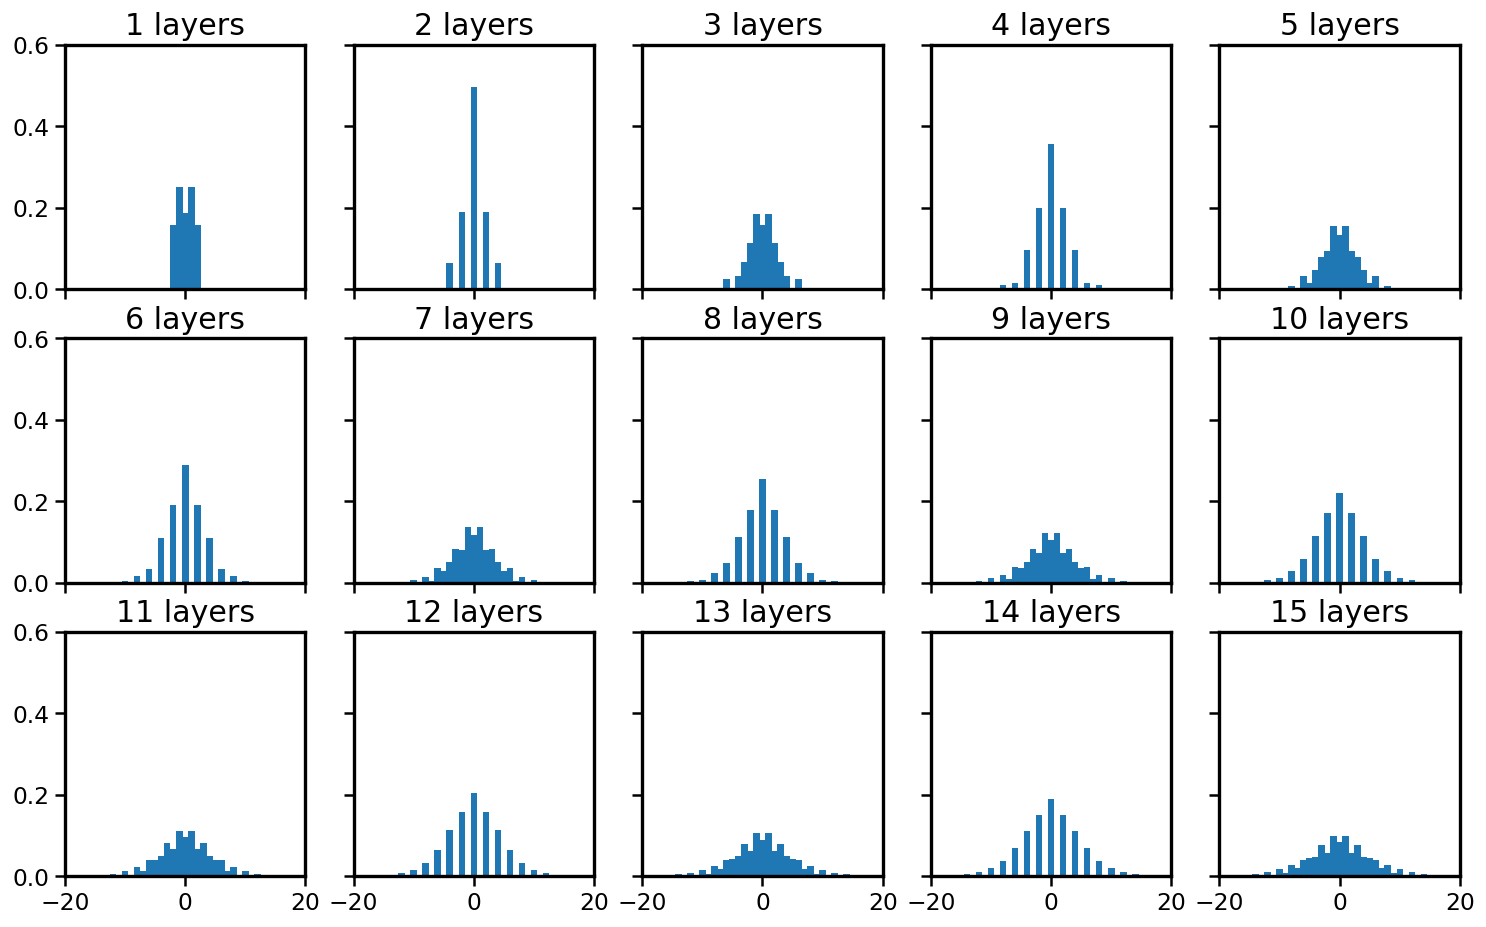

In [46]:
L = 2*numlayers
x = np.arange(-L,L+1)
states_norm = np.sum(np.abs(states_expA4)**2,axis=2)

fig,axs = plt.subplots(3,5,figsize=(15,9), sharex=True, sharey=True)
for k,ax in enumerate(axs.flat):
    ax.bar(x,np.mean(states_norm[:,k,:],axis=0), color = 'C0',width =1.1)
    ax.set_title(f"{k+1} layers",fontsize = 18)
    ax.set_ylim([0,0.6])
    ax.set_xlim([-20,20])


### Check output function in the $\cos(x\pi)$ and $\sin(x\pi)$ basis

In [47]:
# obs = jit(lambda states : measurement(states,M),device=dev)(states[:2500,:,:,:])
obs = jit(lambda states : measurement(states,M),device=dev)(states_expA4)

In [48]:
one,cos,sin = trig_to_sc(obs)
ocs_expA4 = np.concatenate([one,cos,sin],axis=2)
# print(f"The output functions as cos sin decomposition represented by {ocs.shape[2]} coefficient at the end of each of the {ocs.shape[1]} layers was sampled for {ocs.shape[0]} instances of the circuit parameters")
# ocs.shape

In [52]:
Y = []
for k in range(numlayers):
    ys_max, P_L1, P_L2, dys_max, dP_L1, dP_L2 = max_lip(ocs_expA4[:,k,:].T)
    Y.append([ys_max, P_L1, P_L2, dys_max, dP_L1, dP_L2])
Y = np.array(Y)
Y.shape

(50, 6, 2000)

In [53]:
ys_max = Y[:,0,:].flatten()
P_L1 = Y[:,1,:].flatten()
P_L2 = Y[:,2,:].flatten()
dys_max = Y[:,3,:].flatten()
dP_L1 = Y[:,4,:].flatten()
dP_L2 = Y[:,5,:].flatten()

In [54]:
lip_expA4 = [Y[:,3,:],Y[:,4,:]]

## Experiment B4
* A = X4 / 2
* B1 = Y4
* B2 = X4
* B3 = ZZ4
* M = X4 / 4

### Experiment definition

In [55]:
A = pauli_sym('X',4,1)/2
B1 = pauli_sym('X',4,1)
B2 = pauli_sym('Y',4,1)
B3 = pauli_sym('Z',4,2)

Bs = [B1,B2,B3]
M = pauli_sym('X',4,1)/4
N = A.shape[0]

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

### Check State Amplitude in the $e^{ix\pi}$ basis

In [56]:
fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)

In [57]:
states_expB4 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

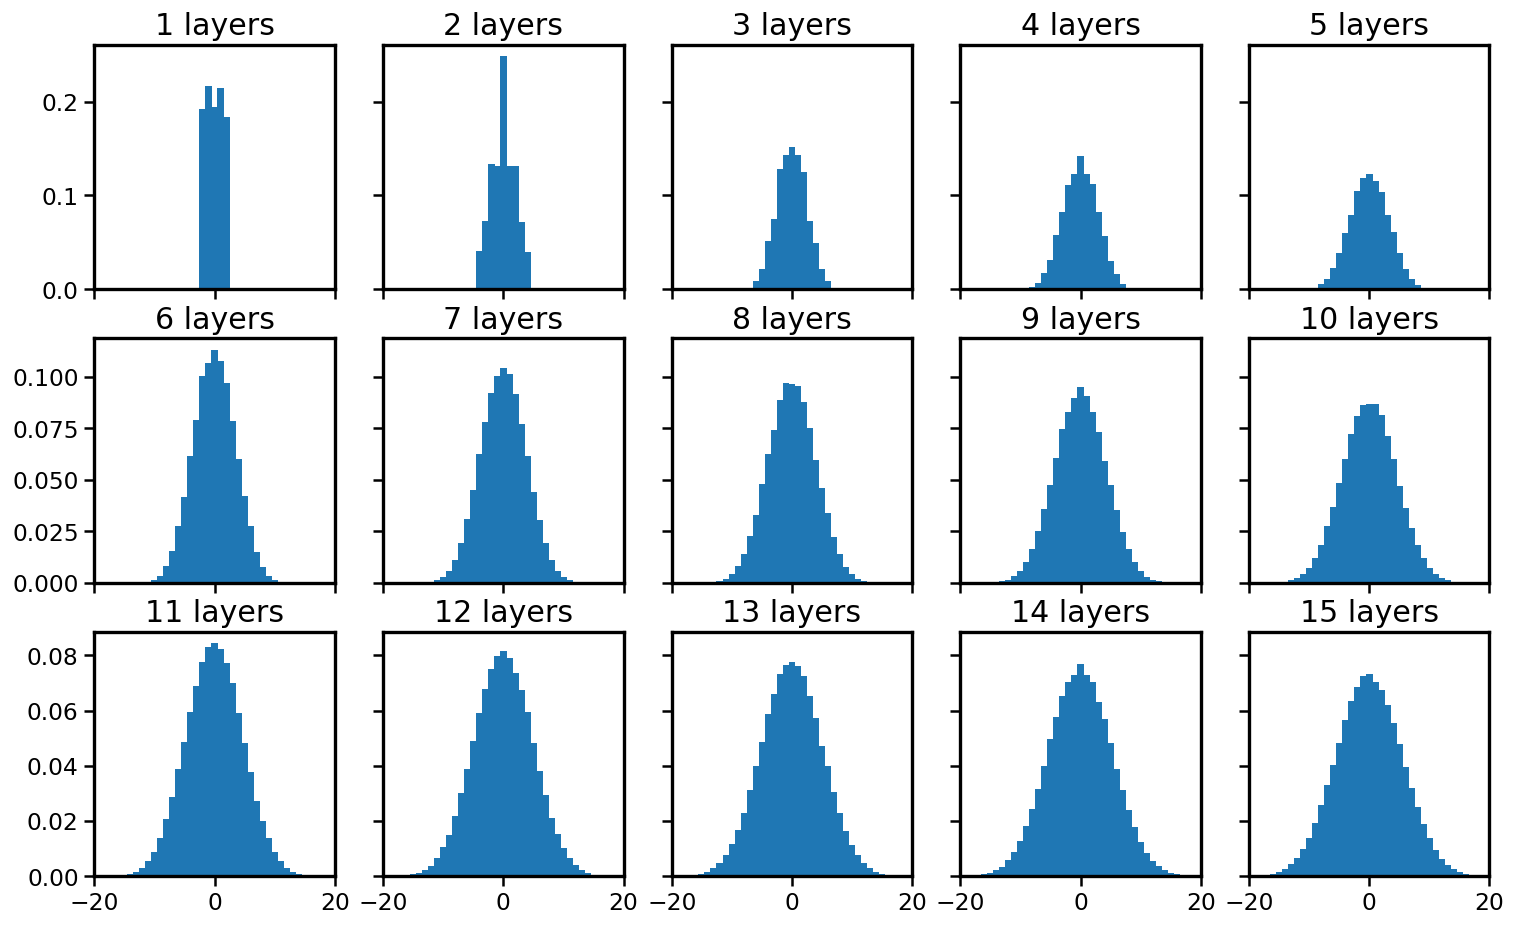

In [58]:
L = 2*numlayers
x = np.arange(-L,L+1)
states_norm = np.sum(np.abs(states_expB4)**2,axis=2)

fig,axs = plt.subplots(3,5,figsize=(15,9), sharex=True, sharey='row')
for k,ax in enumerate(axs.flat):
    ax.bar(x,np.mean(states_norm[:,k,:],axis=0), color = 'C0',width =1.1)
    ax.set_title(f"{k+1} layers",fontsize = 18)
    # ax.set_ylim([0,0.6])
    ax.set_xlim([-20,20])


### Check output function in the $\cos(x\pi)$ and $\sin(x\pi)$ basis

In [59]:
obs = jit(lambda states : measurement(states,M),device=dev)(states_expB4)

In [60]:
one,cos,sin = trig_to_sc(obs)
ocs_expB4 = np.concatenate([one,cos,sin],axis=2)
# print(f"The output functions as cos sin decomposition represented by {ocs.shape[2]} coefficient at the end of each of the {ocs.shape[1]} layers was sampled for {ocs.shape[0]} instances of the circuit parameters")
# ocs.shape

In [61]:
Y = []
for k in range(numlayers):
    ys_max, P_L1, P_L2, dys_max, dP_L1, dP_L2 = max_lip(ocs_expB4[:,k,:].T)
    Y.append([ys_max, P_L1, P_L2, dys_max, dP_L1, dP_L2])
Y = np.array(Y)
Y.shape

(50, 6, 2000)

In [62]:
ys_max = Y[:,0,:].flatten()
P_L1 = Y[:,1,:].flatten()
P_L2 = Y[:,2,:].flatten()
dys_max = Y[:,3,:].flatten()
dP_L1 = Y[:,4,:].flatten()
dP_L2 = Y[:,5,:].flatten()

In [63]:
lip_expB4 = [Y[:,3,:],Y[:,4,:]]

## Experiment C4
* A = X4 / 2
* Bs : Haar random integer spectrum
* M = X4 / 4

In [45]:
n = 4
A = pauli_sym('X',n,1) / 2
print(np.linalg.eigvalsh(A))

# U = unitary_group.rvs(16,random_state=k)
# D = np.diag([-1]*8 + [1]*8)
# B = U @ D @ U.T.conj()
# Bs = [B]

Bs = []
for k in range(5):
    U = unitary_group.rvs(2**n,random_state=k)
    D = np.diag([-1]*2**(n-1) + [1]*2**(n-1))
    B = U @ D @ U.T.conj()
    Bs.append(B)

M = pauli_sym('X',n,1) / n
print(np.abs(np.linalg.eigvalsh(M)).max())
N = A.shape[0]

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

[-2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.98977821e-16 -1.36965797e-16 -1.24964567e-16
  9.12912787e-17  2.98686627e-16  4.17741330e-16  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  2.00000000e+00]
1.0000000000000002


In [46]:
if select_dev:
    fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)
else:
    fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)))

In [47]:
states_expC4 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

## Plot

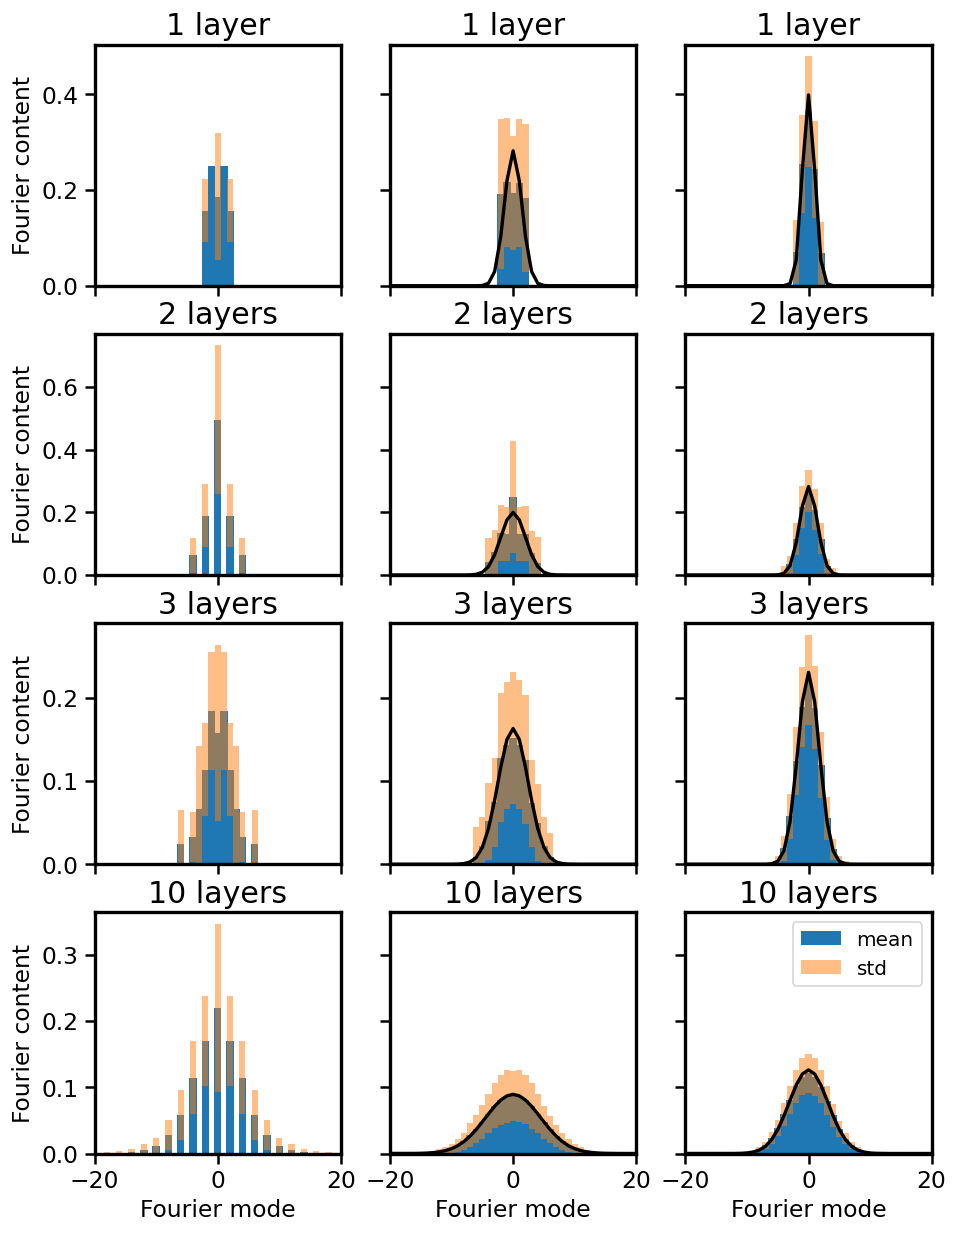

In [72]:
L = numlayers*2
x = np.arange(-L,L+1)
states_norm_expA4 = np.sum(np.abs(states_expA4)**2,axis=2)
states_norm_expB4 = np.sum(np.abs(states_expB4)**2,axis=2)
states_norm_expC4 = np.sum(np.abs(states_expC4)**2,axis=2)
states_norms = [states_norm_expA4,states_norm_expB4,states_norm_expC4]

inds = [0,1,2,9]
fig,axs = plt.subplots(4,3,figsize=(9,12), sharex=True, sharey='row') #

for exp in range(3):
    for k in range(4):
        ax = axs[k,exp]
        
        states_norm = states_norms[exp]
        mu = np.mean(states_norm[:,inds[k],:],axis=0)
        sig = np.std(states_norm[:,inds[k],:],axis=0)
    
        # ax.bar(x,mu, color = 'C0',width =1.2)
        ax.bar(x,mu, color = 'C0',width =1.2,label='mean')
        ax.bar(x,2*sig, color = 'C1',alpha=0.5,width =1, bottom=np.maximum(mu-sig,0),label='std')
        # ax.bar(x,mu-sig, color = 'C0',width =1.2)
        
        # ax.bar(x,np.mean(states_norm[:,inds[k],:],axis=0), color = 'C0',width =1.1)
        if exp==1:
            ax.plot(x,1/np.sqrt(4*(inds[k]+1)*np.pi)*np.exp(-x**2/(inds[k]+1)/4),'k',linewidth=2)
        if exp==2:
            ax.plot(x,1/np.sqrt(2*(inds[k]+1)*np.pi)*np.exp(-x**2/(inds[k]+1)/2),'k',linewidth=2)

        if k==0:
            ax.set_title(f"{inds[k]+1} layer",fontsize = 18)
        else:
            ax.set_title(f"{inds[k]+1} layers",fontsize = 18)
        ax.set_xlim([-20,+20])
        if k==3:
            ax.set_xlabel('Fourier mode')
        if exp==0:
            ax.set_ylabel('Fourier content')
        # ax.grid(which='both')
ax.legend()
fig.savefig('kernels_QRU.pdf')

### Experiment definition

In [35]:
A = pauli_sym('X',4,1) / 2

# U = unitary_group.rvs(16,random_state=k)
# D = np.diag([-1]*8 + [1]*8)
# B = U @ D @ U.T.conj()
# Bs = [B]

Bs = []
for k in range(5):
    U = unitary_group.rvs(16,random_state=k)
    D = np.diag([-1]*8 + [1]*8)
    B = U @ D @ U.T.conj()
    Bs.append(B)

M = pauli_sym('X',4,1) / 4
N = A.shape[0]

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

### Check State Amplitude in the $e^{ix\pi}$ basis

In [36]:
if select_dev:
    fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)
else:
    fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)))

In [37]:
states_expC4 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

### Check output function in the $\cos(x\pi)$ and $\sin(x\pi)$ basis

In [38]:
if select_dev:
    obs = jit(lambda states : measurement(states,M),device=dev)(states_expC4)
else:
    obs = jit(lambda states : measurement(states,M))(states_expC4)

In [39]:
one,cos,sin = trig_to_sc(obs)
ocs_expC4 = np.concatenate([one,cos,sin],axis=2)
# print(f"The output functions as cos sin decomposition represented by {ocs.shape[2]} coefficient at the end of each of the {ocs.shape[1]} layers was sampled for {ocs.shape[0]} instances of the circuit parameters")
# ocs.shape

In [40]:
Y = []
for k in range(numlayers):
    ys_max, P_L1, P_L2, dys_max, dP_L1, dP_L2 = max_lip(ocs_expC4[:,k,:].T)
    Y.append([ys_max, P_L1, P_L2, dys_max, dP_L1, dP_L2])
Y = np.array(Y)
Y.shape

(50, 6, 2000)

In [41]:
ys_max = Y[:,0,:].flatten()
P_L1 = Y[:,1,:].flatten()
P_L2 = Y[:,2,:].flatten()
dys_max = Y[:,3,:].flatten()
dP_L1 = Y[:,4,:].flatten()
dP_L2 = Y[:,5,:].flatten()

In [42]:
lip_expC4 = [Y[:,3,:],Y[:,4,:]]

# Sigma num qubits

In [9]:
numlayers = 10
numthes = 2000

## Experiment C2
* A = X6 / 2
* Bs : Haar random integer spectrum
* M = A / 6

In [42]:
n = 2
A = pauli_sym('X',n,1) / 2
print(np.linalg.eigvalsh(A))

# U = unitary_group.rvs(16,random_state=k)
# D = np.diag([-1]*8 + [1]*8)
# B = U @ D @ U.T.conj()
# Bs = [B]

Bs = []
for k in range(5):
    U = unitary_group.rvs(2**n,random_state=k)
    D = np.diag([-1]*2**(n-1) + [1]*2**(n-1))
    B = U @ D @ U.T.conj()
    Bs.append(B)

M = pauli_sym('X',n,1) / n
print(np.abs(np.linalg.eigvalsh(M)).max())
N = A.shape[0]

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

[-1.00000000e+00 -1.45255575e-17  1.91876268e-17  1.00000000e+00]
1.0


In [43]:
if select_dev:
    fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)
else:
    fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)))

In [44]:
states_expC2 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

## Experiment C4
* A = X4 / 2
* Bs : Haar random integer spectrum
* M = X4 / 4

In [45]:
n = 4
A = pauli_sym('X',n,1) / 2
print(np.linalg.eigvalsh(A))

# U = unitary_group.rvs(16,random_state=k)
# D = np.diag([-1]*8 + [1]*8)
# B = U @ D @ U.T.conj()
# Bs = [B]

Bs = []
for k in range(5):
    U = unitary_group.rvs(2**n,random_state=k)
    D = np.diag([-1]*2**(n-1) + [1]*2**(n-1))
    B = U @ D @ U.T.conj()
    Bs.append(B)

M = pauli_sym('X',n,1) / n
print(np.abs(np.linalg.eigvalsh(M)).max())
N = A.shape[0]

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

[-2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.98977821e-16 -1.36965797e-16 -1.24964567e-16
  9.12912787e-17  2.98686627e-16  4.17741330e-16  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  2.00000000e+00]
1.0000000000000002


In [46]:
if select_dev:
    fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)
else:
    fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)))

In [47]:
states_expC4 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

## Experiment C6
* A = X6 / 2
* Bs : Haar random integer spectrum
* M = A / 6

In [48]:
n = 6
A = pauli_sym('X',n,1) / 2
print(np.linalg.eigvalsh(A))

# U = unitary_group.rvs(16,random_state=k)
# D = np.diag([-1]*8 + [1]*8)
# B = U @ D @ U.T.conj()
# Bs = [B]

Bs = []
for k in range(5):
    U = unitary_group.rvs(2**n,random_state=k)
    D = np.diag([-1]*2**(n-1) + [1]*2**(n-1))
    B = U @ D @ U.T.conj()
    Bs.append(B)

M = pauli_sym('X',n,1) / n
print(np.abs(np.linalg.eigvalsh(M)).max())
N = A.shape[0]

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

[-3.00000000e+00 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -2.14955888e-15 -1.16689424e-15
 -8.41861052e-16 -7.72550590e-16 -4.55948921e-16 -3.21759366e-16
 -2.54631325e-16 -1.57797961e-16 -1.28844789e-16 -1.18808107e-16
  5.89961790e-17  2.05397087e-16  2.63677968e-16  2.68029511e-16
  3.41833322e-16  4.25320384e-16  6.81509831e-16  8.62666843e-16
  9.86456922e-16  1.52042997e-15  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  2.00000000e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000

In [49]:
if select_dev:
    fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)
else:
    fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)))

In [50]:
states_expC6 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

## Experiment C8
* A = X8 / 2
* Bs : Haar random integer spectrum
* M = X8 / 8

In [51]:
n = 8
A = pauli_sym('X',n,1) / 2

# U = unitary_group.rvs(16,random_state=k)
# D = np.diag([-1]*8 + [1]*8)
# B = U @ D @ U.T.conj()
# Bs = [B]

Bs = []
for k in range(5):
    U = unitary_group.rvs(2**n,random_state=k)
    D = np.diag([-1]*2**(n-1) + [1]*2**(n-1))
    B = U @ D @ U.T.conj()
    Bs.append(B)

M = pauli_sym('X',n,1) / n
N = A.shape[0]

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

In [52]:
if select_dev:
    fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)
else:
    fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)))

In [53]:
states_expC8 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

## Experiment B2
* A = X2 / 2
* B1 = Y2
* B2 = X2
* B3 = ZZ
* M = X2 / 2

In [93]:
n = 2
A = pauli_sym('X',n,1)/2
print(np.linalg.eigvalsh(A))

B1 = pauli_sym('X',n,1)
B2 = pauli_sym('Y',n,1)
B3 = pauli_sym('Z',n,2)

Bs = [B1,B2,B3]
M = pauli_sym('X',n,1)/ n
print(np.abs(np.linalg.eigvalsh(M)).max())
N = A.shape[0]

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

[-1.00000000e+00 -1.45255575e-17  1.91876268e-17  1.00000000e+00]
1.0


In [94]:
fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)

In [95]:
states_expB2 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

## Experiment B4
* A = X4 / 2
* B1 = Y4
* B2 = X4
* B3 = ZZ4
* M = X4 / 4

In [96]:
n = 4
A = pauli_sym('X',n,1)/2
print(np.linalg.eigvalsh(A))

B1 = pauli_sym('X',n,1)
B2 = pauli_sym('Y',n,1)
B3 = pauli_sym('Z',n,2)

Bs = [B1,B2,B3]
M = pauli_sym('X',n,1)/ n
print(np.abs(np.linalg.eigvalsh(M)).max())
N = A.shape[0]

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

[-2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.98977821e-16 -1.36965797e-16 -1.24964567e-16
  9.12912787e-17  2.98686627e-16  4.17741330e-16  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  2.00000000e+00]
1.0000000000000002


In [97]:
fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)

In [98]:
states_expB4 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

## Experiment B6
* A = X6 / 2
* B1 = Y6
* B2 = X6
* B3 = ZZ6
* M = X6 / 6

In [99]:
n = 6
A = pauli_sym('X',n,1)/2
print(np.linalg.eigvalsh(A))

B1 = pauli_sym('X',n,1)
B2 = pauli_sym('Y',n,1)
B3 = pauli_sym('Z',n,2)

Bs = [B1,B2,B3]
M = pauli_sym('X',n,1)/ n
print(np.abs(np.linalg.eigvalsh(M)).max())
N = A.shape[0]

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

[-3.00000000e+00 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -2.14955888e-15 -1.16689424e-15
 -8.41861052e-16 -7.72550590e-16 -4.55948921e-16 -3.21759366e-16
 -2.54631325e-16 -1.57797961e-16 -1.28844789e-16 -1.18808107e-16
  5.89961790e-17  2.05397087e-16  2.63677968e-16  2.68029511e-16
  3.41833322e-16  4.25320384e-16  6.81509831e-16  8.62666843e-16
  9.86456922e-16  1.52042997e-15  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  2.00000000e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000

In [100]:
fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)

In [101]:
states_expB6 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

## Experiment B8
* A = X8 / 2
* B1 = Y8
* B2 = X8
* B3 = ZZ8
* M = X8 / 8

In [102]:
n = 8
A = pauli_sym('X',n,1)/2
print(np.linalg.eigvalsh(A))

B1 = pauli_sym('X',n,1)
B2 = pauli_sym('Y',n,1)
B3 = pauli_sym('Z',n,2)

Bs = [B1,B2,B3]
M = pauli_sym('X',n,1)/ n
print(np.abs(np.linalg.eigvalsh(M)).max())
N = A.shape[0]

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

[-4.00000000e+00 -3.00000000e+00 -3.00000000e+00 -3.00000000e+00
 -3.00000000e+00 -3.00000000e+00 -3.00000000e+00 -3.00000000e+00
 -3.00000000e+00 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00
 -2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000

In [103]:
fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)

In [104]:
states_expB8 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

## plot

In [117]:
states_expC = [states_expC2,states_expC4,states_expC6,states_expC8]
sC = []
for states_expCk in states_expC:
    a = np.mean(np.sum(np.abs(states_expCk)**2,axis=2),axis=0)
    L = (a.shape[1]-1)//2
    ks = np.expand_dims(np.arange(-L,L+1),axis=0)
    sC.append(np.sqrt(np.sum(a*ks**2,axis=1)))
sC = np.array(sC)
sC.shape

(4, 10)

In [105]:
states_expB = [states_expB2,states_expB4,states_expB6,states_expB8]
sB = []
for states_expBk in states_expB:
    a = np.mean(np.sum(np.abs(states_expBk)**2,axis=2),axis=0)
    L = (a.shape[1]-1)//2
    ks = np.expand_dims(np.arange(-L,L+1),axis=0)
    sB.append(np.sqrt(np.sum(a*ks**2,axis=1)))
sB = np.array(sB)
sB.shape

(4, 10)

In [122]:
# fun_sign = lambda n : np.sum(scipy.special.binom(n,np.arange(0,n+1))*np.arange(-n//2,n//2+1)**2)/np.sum(scipy.special.binom(n,np.arange(0,n+1)))
fun_sign_C = lambda n : n/4

In [123]:
fun_sign_B = lambda n : n*(n+2)/12

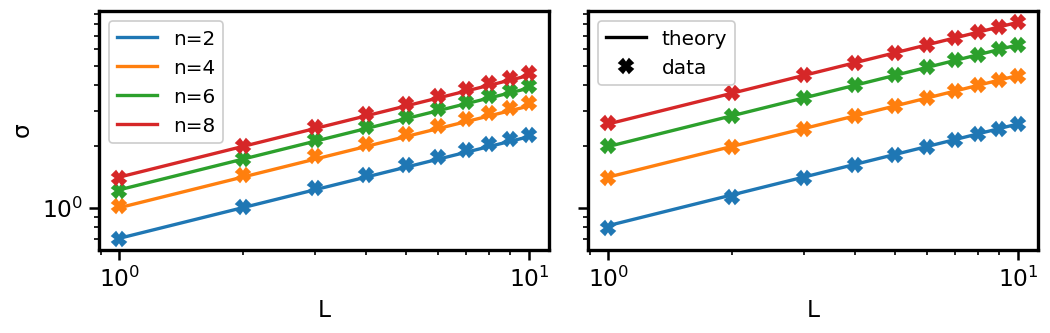

In [147]:
fig,axs = plt.subplots(1,2,figsize=(9,3),sharey=True)

for k in range(4):
    axs[0].loglog(np.arange(1,11),sC[k].T,'X',color=f"C{k}")
    axs[0].loglog(np.arange(1,11),np.sqrt(np.arange(1,11)*fun_sign_C((k+1)*2)),color=f"C{k}",label=f"n={(k+1)*2}")

for k in range(4):
    axs[1].loglog(np.arange(1,11),sB[k].T,'X',color=f"C{k}")
    axs[1].loglog(np.arange(1,11),np.sqrt(np.arange(1,11)*fun_sign_B((k+1)*2)),color=f"C{k}",label=f"n={(k+1)*2}")

lines1 = [Line2D([0], [0], color='C0', lw=2, ls = '-'), 
          Line2D([0], [0], color='C1', lw=2, ls = '-'),
          Line2D([0], [0], color='C2', lw=2, ls = '-'),
          Line2D([0], [0], color='C3', lw=2, ls = '-'),]
lines2 = [Line2D([0], [0], color='k', lw=2, ls = '-'), 
          Line2D([0], [0], color='k', lw=0, marker='X')]
labels1 = [f"n={n}" for n in [2,4,6,8]] 
labels2 = ['theory','data']

axs[0].legend(lines1, labels1, framealpha=1)
axs[1].legend(lines2, labels2, framealpha=1)

axs[0].set_xlabel('L')
axs[1].set_xlabel('L')
axs[0].set_ylabel('$\sigma$')

fig.tight_layout()
fig.savefig('sigma_QRU.pdf')

# Lipschitz 

In [148]:
numlayers = 10
numthes = 2000

## Experiment B4
* A = X4 / 2
* B1 = Y4
* B2 = X4
* B3 = ZZ4
* M = X4 / 4

In [152]:
A = pauli_sym('X',4,1)/2
B1 = pauli_sym('X',4,1)
B2 = pauli_sym('Y',4,1)
B3 = pauli_sym('Z',4,2)

Bs = [B1,B2,B3]
M = pauli_sym('X',4,1)/4
N = A.shape[0]

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

In [153]:
fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)

In [154]:
states_expB4 = fun_states(thes)
# print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

In [155]:
obs = jit(lambda states : measurement(states,M),device=dev)(states_expB4)

In [156]:
one,cos,sin = trig_to_sc(obs)
ocs_expB4 = np.concatenate([one,cos,sin],axis=2)
# print(f"The output functions as cos sin decomposition represented by {ocs.shape[2]} coefficient at the end of each of the {ocs.shape[1]} layers was sampled for {ocs.shape[0]} instances of the circuit parameters")
# ocs.shape

In [157]:
Y = []
for k in range(numlayers):
    ys_max, P_L1, P_L2, dys_max, dP_L1, dP_L2 = max_lip(ocs_expB4[:,k,:].T)
    Y.append([ys_max, P_L1, P_L2, dys_max, dP_L1, dP_L2])
Y = np.array(Y)
Y.shape

(10, 6, 2000)

In [158]:
ys_max = Y[:,0,:].flatten()
P_L1 = Y[:,1,:].flatten()
P_L2 = Y[:,2,:].flatten()
dys_max = Y[:,3,:].flatten()
dP_L1 = Y[:,4,:].flatten()
dP_L2 = Y[:,5,:].flatten()

In [159]:
lip_expB4 = np.array([Y[:,3,:],Y[:,4,:]])

In [160]:
lip_expB4.shape

(2, 10, 2000)

## Plot

In [168]:
a = np.sort(lip_expB4,axis=2)

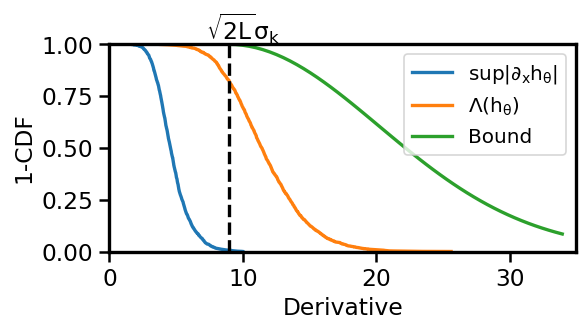

In [240]:
fig = plt.figure(figsize=(5,3))
plt.plot(a[0,-1],1-np.linspace(0,1,a.shape[2]),label=r'$sup|\partial_x h_{\theta}|$')
plt.plot(a[1,-1],1-np.linspace(0,1,a.shape[2]),label=r'$\Lambda(h_{\theta})$')
L=10
sig = fun_sign_B(4)
a0 = np.sqrt(2*L)*sig
plt.plot([a0,a0],[0,1],'k--')
plt.text(7.25,1.02,r'$\sqrt{2L}\sigma_k$')

t = np.linspace(0,25)
bt = np.exp(-t**2/(np.sqrt(L)*sig)**3)
plt.plot(t+a0,bt,label='Bound')
plt.xlabel("Derivative")
plt.ylabel("1-CDF")
plt.legend()
plt.ylim([0,1])
plt.xlim([0,35])

fig.tight_layout()
fig.savefig('lipschitz_QRU.pdf')

# useless

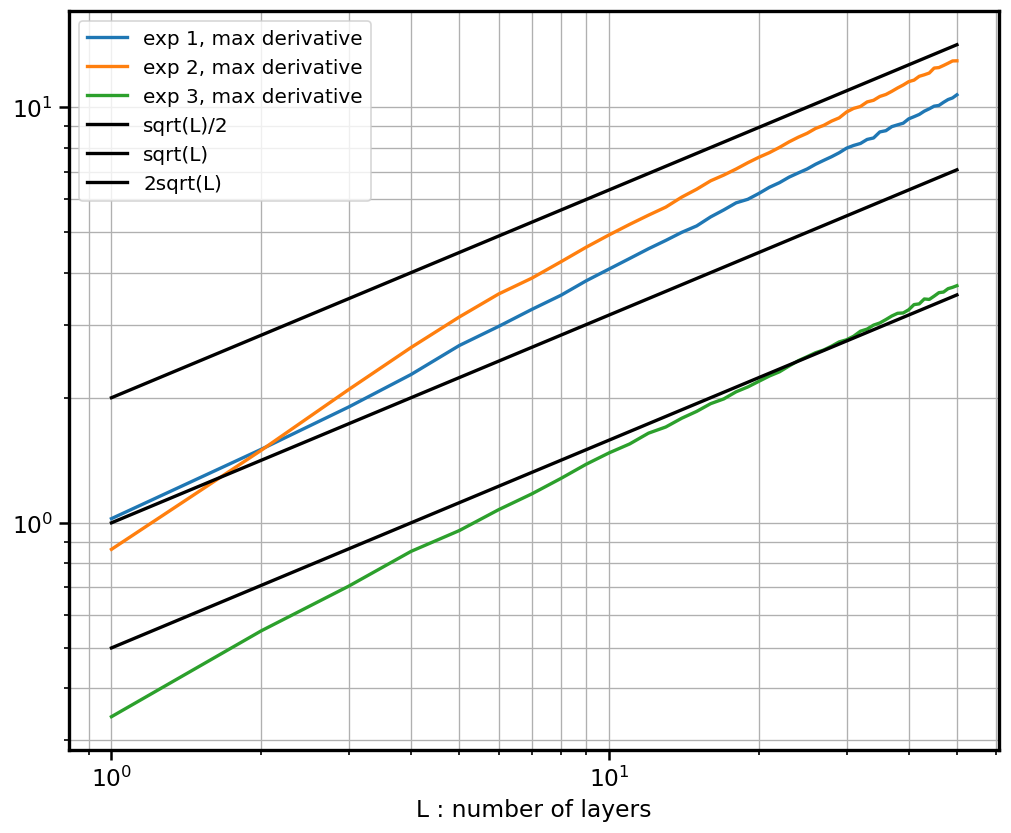

In [73]:
ks = np.arange(1,numlayers+1)
plt.loglog(ks,np.mean(lip_expA4[0],axis=1),color='C0',label='exp 1, max derivative')
# plt.loglog(ks,np.mean(lip_exp1[1],axis=1),'--',color='C0',label='exp 1, L1 norm')
plt.loglog(ks,np.mean(lip_expB4[0],axis=1),color='C1',label='exp 2, max derivative')
# plt.loglog(ks,np.mean(lip_exp2[1],axis=1),'--',color='C1',label='exp 2, L1 norm')
plt.loglog(ks,np.mean(lip_expC4[0],axis=1),color='C2',label='exp 3, max derivative')
# plt.loglog(ks,np.mean(lip_exp3[1],axis=1),'--',color='C2',label='exp 3, L1 norm')

plt.loglog(ks,np.sqrt(ks)/2,'k',label='sqrt(L)/2')
plt.loglog(ks,np.sqrt(ks),'k',label='sqrt(L)')
plt.loglog(ks,2*np.sqrt(ks),'k',label='2sqrt(L)')
# plt.loglog(ks,ks,'k--',label='L')
plt.xlabel('L : number of layers')
plt.legend()
plt.grid(which='both')

fig.savefig('lipschitz_QRU.pdf')

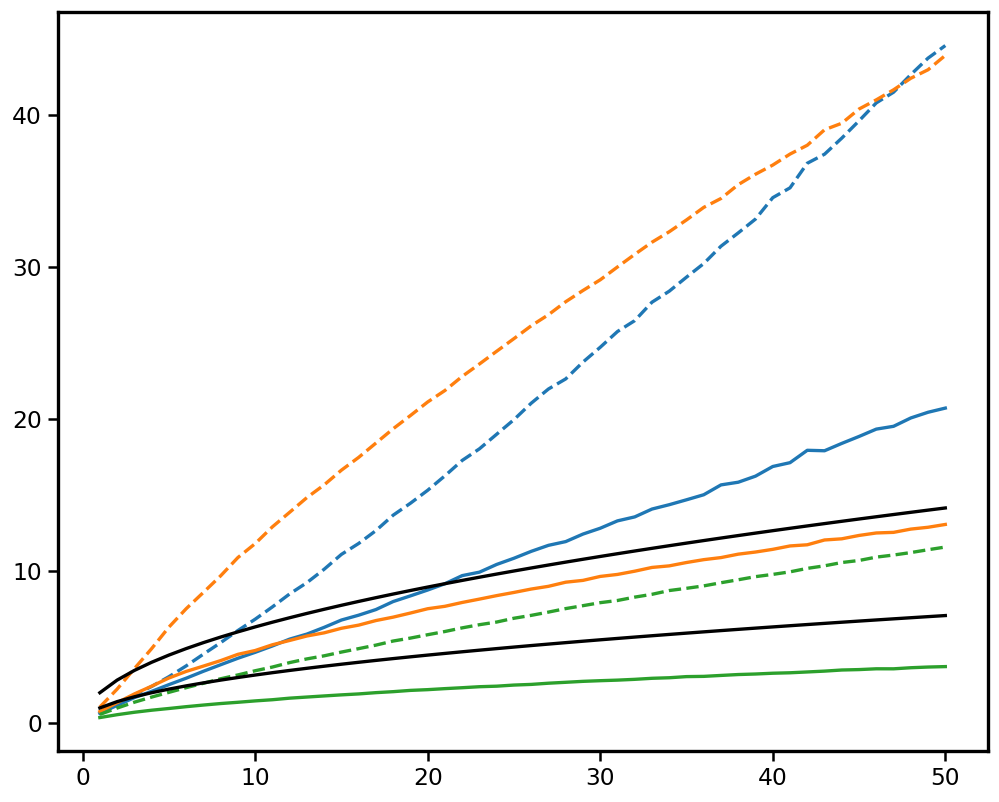

In [83]:
ks = np.arange(1,numlayers+1)
plt.plot(ks,np.mean(lip_exp1[0],axis=1),color='C0')
plt.plot(ks,np.mean(lip_exp1[1],axis=1),'--',color='C0')
plt.plot(ks,np.mean(lip_exp2[0],axis=1),color='C1')
plt.plot(ks,np.mean(lip_exp2[1],axis=1),'--',color='C1')
plt.plot(ks,np.mean(lip_exp3[0],axis=1),color='C2')
plt.plot(ks,np.mean(lip_exp3[1],axis=1),'--',color='C2')


plt.plot(ks,np.sqrt(ks),'k')
plt.plot(ks,2*np.sqrt(ks),'k')

fig.savefig('lipschitz_QRU.pdf')

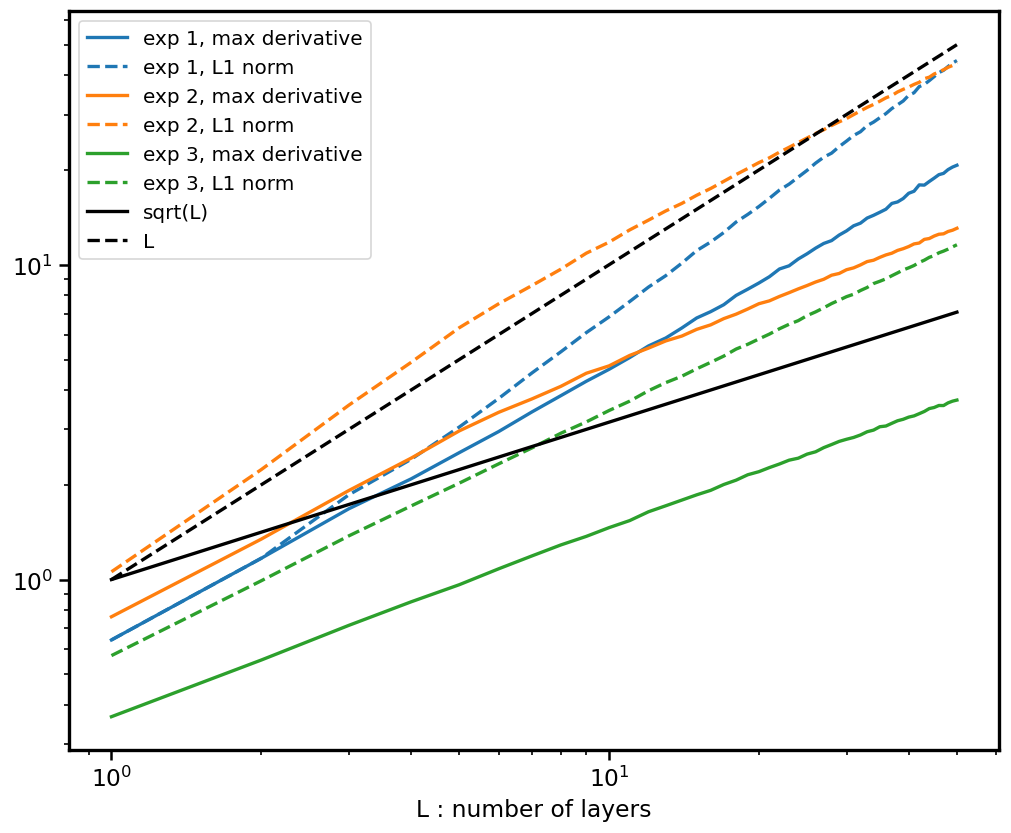

In [72]:
ks = np.arange(1,numlayers+1)
plt.loglog(ks,np.mean(lip_exp1[0],axis=1),color='C0',label='exp 1, max derivative')
plt.loglog(ks,np.mean(lip_exp1[1],axis=1),'--',color='C0',label='exp 1, L1 norm')
plt.loglog(ks,np.mean(lip_exp2[0],axis=1),color='C1',label='exp 2, max derivative')
plt.loglog(ks,np.mean(lip_exp2[1],axis=1),'--',color='C1',label='exp 2, L1 norm')
plt.loglog(ks,np.mean(lip_exp3[0],axis=1),color='C2',label='exp 3, max derivative')
plt.loglog(ks,np.mean(lip_exp3[1],axis=1),'--',color='C2',label='exp 3, L1 norm')

plt.loglog(ks,np.sqrt(ks),'k',label='sqrt(L)')
plt.loglog(ks,ks,'k--',label='L')
plt.xlabel('L : number of layers')
plt.legend()

In [76]:
ocs_exp3.shape

(2000, 50, 401)

(0.0, 50.0)

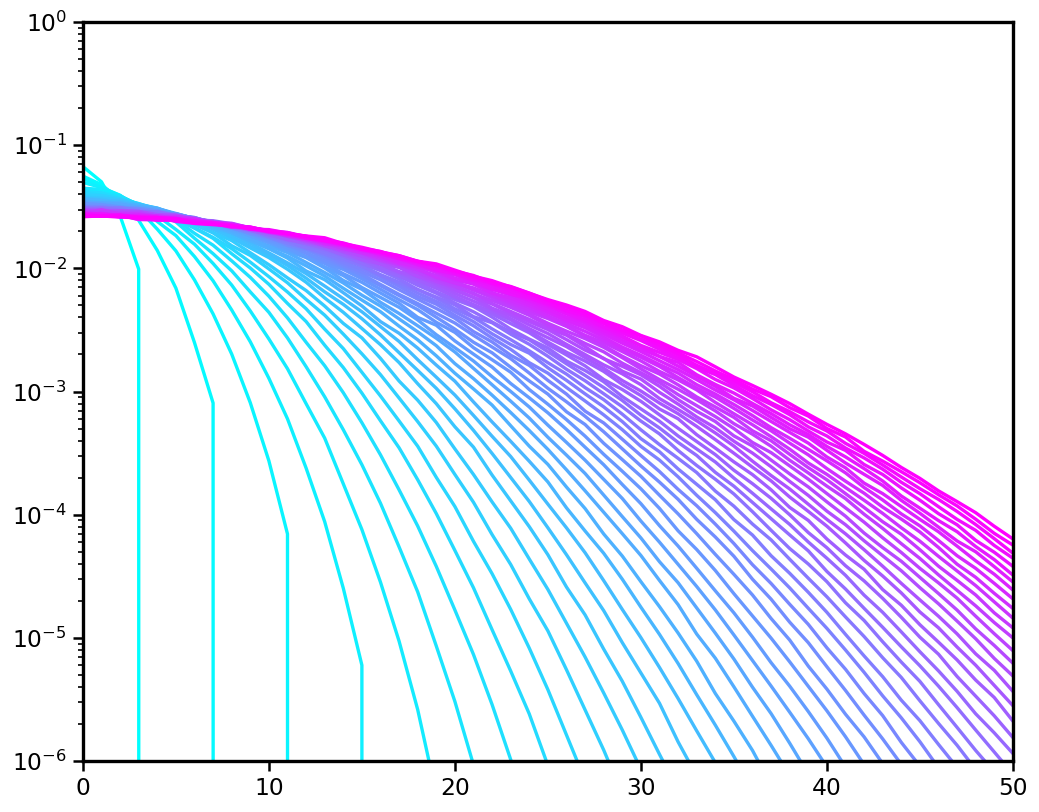

In [81]:
for k in range(numlayers):
    plt.semilogy(np.mean(np.abs(ocs_exp3[:,k,1:201]),axis=0).T,c=cmap(k/(numlayers-1)),label=f"# layers = {k+1}")
# plt.plot([0,out_fun.shape[2]],[1,1],'k')
# plt.xlabel('coefficients for cos and then for sin')
# plt.ylabel('mean(abs(coef))')
plt.ylim([1e-6,1])
plt.xlim([0,50])
# plt.legend()

Text(0, 0.5, 'mean(abs(coef))')

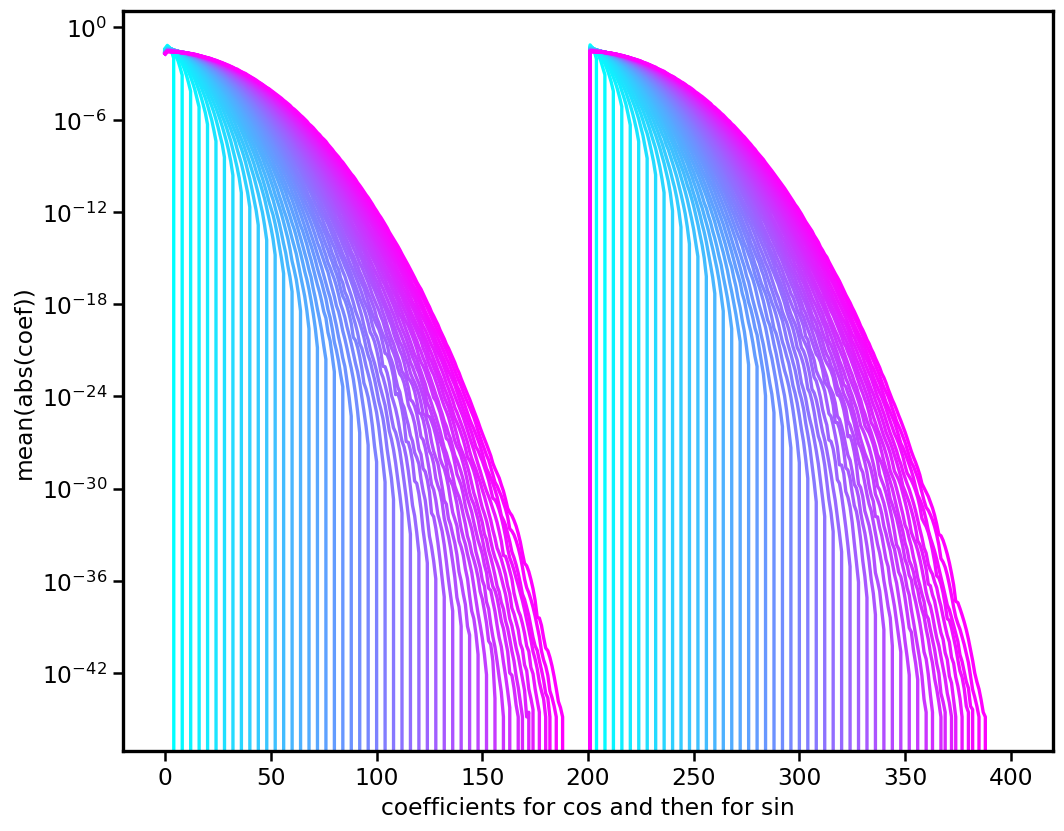

In [39]:
for k in range(numlayers):
    plt.semilogy(np.mean(np.abs(ocs[:,k,:]),axis=0).T,c=cmap(k/(numlayers-1)),label=f"# layers = {k+1}")
# plt.plot([0,out_fun.shape[2]],[1,1],'k')
plt.xlabel('coefficients for cos and then for sin')
plt.ylabel('mean(abs(coef))')
# plt.legend()

0
3


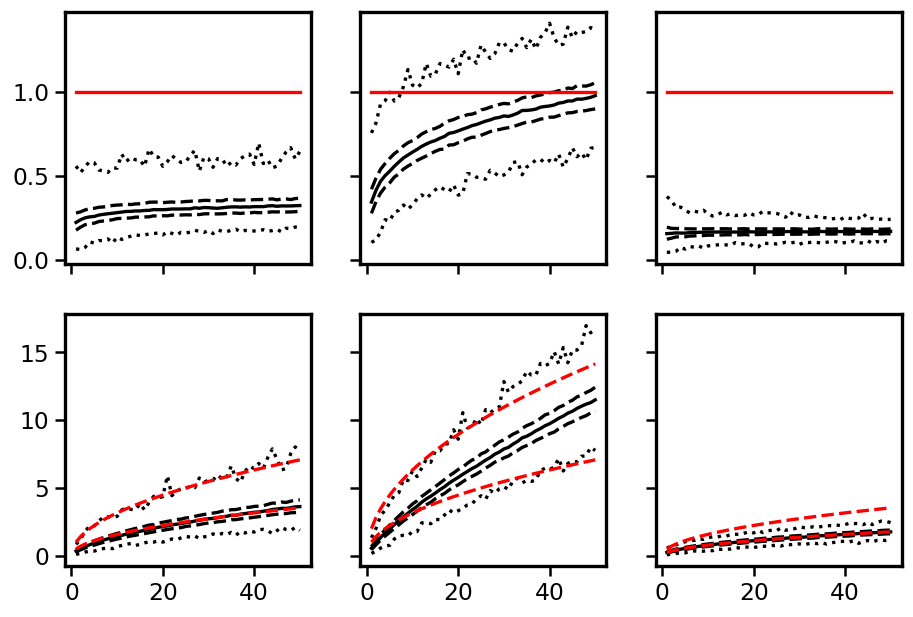

In [56]:
fig, axs = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey='row')
ks = np.arange(1,51)

for (k,ax) in enumerate(axs.flat):
    a = Y[:,k,:]
    mina = np.min(a,axis=1)
    maxa = np.max(a,axis=1)

    ax.plot(ks,np.percentile(a, 50,axis=1),'k')
    ax.plot(ks,np.percentile(a, 25,axis=1),'k--')
    ax.plot(ks,np.percentile(a, 75,axis=1),'k--')
    ax.plot(ks,mina,'k:')
    ax.plot(ks,maxa,'k:')

print(np.sum(Y[:,0]>Y[:,1]))
print(np.sum(Y[:,2]>Y[:,3]))

axs[0,0].plot(ks,0*ks+1,'r')
axs[0,1].plot(ks,0*ks+1,'r')
axs[0,2].plot(ks,0*ks+1,'r')
# axs[1,0].plot(ks,ks,'r')
axs[1,0].plot(ks,np.sqrt(ks),'r--')
axs[1,0].plot(ks,np.sqrt(ks)/2,'r--')
# axs[1,1].plot(ks,ks,'r')
axs[1,1].plot(ks,np.sqrt(ks),'r--')
axs[1,1].plot(ks,np.sqrt(ks)*2,'r--')
axs[1,2].plot(ks,np.sqrt(ks)/4,'r--')
axs[1,2].plot(ks,np.sqrt(ks)/2,'r--')